In [2]:
! pip install scikit-learn matplotlib numpy torch vllm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
! pip install vllm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import torch
from torch import Tensor
import numpy as np
import re
import math
from collections import Counter
from vllm import LLM, SamplingParams
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple

# --- Constants for Clustering ---
PCA_COMPONENTS = 10
TSNE_COMPONENTS = 2
DISTANCE_THRESHOLD = 0.10

# A set of common English stopwords
STOPWORDS = {
    'a', 'an', 'the', 'and', 'but', 'or', 'so', 'if', 'for', 'of', 'in', 'to', 'on', 'with', 'by', 'at', 'from',
    'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'he', 'she', 'it',
    'they', 'we', 'you', 'i', 'that', 'which', 'who', 'what', 'when', 'where', 'why', 'how', 'about', 'above',
    'after', 'below', 'between', 'down', 'during', 'into', 'out', 'over', 'through', 'under', 'up', 'no',
    'not', 'only', 'very', 's', 't'
}

print("Setup complete.")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 08-24 16:02:13 [__init__.py:241] Automatically detected platform cpu.
Setup complete.


In [9]:
# Clear existing model from memory
if 'llm' in globals():
    del llm

# Clear CUDA cache
import torch
torch.cuda.empty_cache()

# Check memory
import subprocess
result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
print(result.stdout)

import os
# Force V0 engine by setting environment variable
os.environ['VLLM_USE_V1'] = '0'

# --- Load the model into the vLLM engine ---
print("Loading Llama 3.1 8B Instruct model with vLLM...")
llm = LLM(
    model="meta-llama/Llama-3.1-8B-Instruct",
    max_model_len=2048,
    gpu_memory_utilization=0.80,
    enforce_eager=True,
    max_logprobs=100
)
print("Model loaded successfully with V0 engine.")

FileNotFoundError: [Errno 2] No such file or directory: 'nvidia-smi'

In [126]:
def filter_and_clean_tokens(tokens: List[str], probabilities: List[float]) -> Tuple[List[str], List[float]]:
    """
    Filters out unwanted tokens:
    - Special control tokens like <|...|>
    - Stopwords
    - Non-linguistic fragments (no letters)
    - Single-character tokens (except 'a' and 'i')
    """
    cleaned_tokens = []
    cleaned_probs = []

    for token, prob in zip(tokens, probabilities):
        token_str = token.strip()

        # Rule 0: reject any special control tokens like <|eot_id|>
        if re.match(r"^<\|.*\|>$", token_str):
            continue

        # Rule 1: reject empty strings, stopwords, or strings with no letters
        if not token_str or token_str.lower() in STOPWORDS or not re.search(r"[a-zA-Z]", token_str):
            continue

        # Rule 2: reject single chars unless it's 'a' or 'i'
        if len(token_str) == 1 and token_str.lower() not in {"a", "i"}:
            continue

        cleaned_tokens.append(token_str)
        cleaned_probs.append(prob)

    return cleaned_tokens, cleaned_probs

def get_llama_embeddings(llm_object, token_ids: Tensor | list[int]) -> Tensor:
    """
    Gets the embedding vectors for the provided token IDs directly from
    the model's final output embedding matrix (lm_head.weight).
    This provides a more stable "conceptual" representation than
    the context-dependent hidden state.
    """
    # Ensure token_ids is a tensor
    if not isinstance(token_ids, torch.Tensor):
        token_ids = torch.tensor(token_ids, dtype=torch.long)

    # Move token_ids to the same device as the model
    device = llm_object.llm_engine.model_executor.driver_worker.device
    token_ids = token_ids.to(device)

    # Get the underlying transformer model from the vLLM engine
    model = llm_object.llm_engine.model_executor.driver_worker.model_runner.model

    # Access the final LM head weight matrix
    embedding_matrix = model.lm_head.weight

    # Gather embeddings for the given tokens
    return embedding_matrix[token_ids].float().cpu()
   
def reduce_and_cluster_embeddings(embeddings: NDArray) -> tuple[NDArray, NDArray]:
    """
    Performs dimensionality reduction and clustering.
    Returns both 2D embeddings and cluster labels.
    This version is robust to cases with very few candidate tokens.
    """
    if embeddings.shape[0] <= 1:
        return embeddings, np.array([0]) if embeddings.shape[0] == 1 else np.array([])

    # --- Dynamic PCA component count ---
    n_samples = embeddings.shape[0]
    dynamic_pca_components = min(PCA_COMPONENTS, n_samples)
    
    # Optional PCA pre-reduction
    if embeddings.shape[1] > dynamic_pca_components and dynamic_pca_components > 1:
        pca = PCA(n_components=dynamic_pca_components)
        embeddings_reduced = pca.fit_transform(embeddings)
    else:
        embeddings_reduced = embeddings

    # --- t-SNE to 2D ---
    perplexity = min(30.0, float(embeddings_reduced.shape[0] - 1))
    if perplexity > 0:
        tsne = TSNE(
            n_components=TSNE_COMPONENTS,
            init="pca",
            perplexity=perplexity,
            random_state=42
        )
        reduced_embeddings_2d = tsne.fit_transform(embeddings_reduced)
    else:
        reduced_embeddings_2d = embeddings_reduced  # fallback if not enough points

    # --- Agglomerative Clustering ---
    clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=DISTANCE_THRESHOLD,
        metric="cosine",
        linkage="average"
    )
    cluster_labels = clustering.fit_predict(reduced_embeddings_2d)

    return reduced_embeddings_2d, cluster_labels

def rank_concepts(tokens: list[str], probabilities: list[float], cluster_labels: NDArray) -> list[dict]:
   """Ranks clusters by summing the probabilities of the tokens within them."""
   unique_clusters = np.unique(cluster_labels)
   ranked_concepts = []
   token_to_prob = {token: prob for token, prob in zip(tokens, probabilities)}
   for cluster_id in unique_clusters:
       concept_tokens = [token for i, token in enumerate(tokens) if cluster_labels[i] == cluster_id]
       if not concept_tokens: continue
       cluster_score = sum(token_to_prob.get(token, 0) for token in concept_tokens)
       ranked_concepts.append({"id": cluster_id, "tokens": concept_tokens, "score": cluster_score})
   ranked_concepts.sort(key=lambda x: x["score"], reverse=True)
   return ranked_concepts

def select_token_from_best_concept(best_concept: dict, all_predictions: dict[str, float]) -> str | None:
   """Selects the token with the highest original probability from the winning concept cluster."""
   return max(best_concept["tokens"], key=lambda token: all_predictions.get(token, -1), default=None)

print("Helper functions defined.")

Helper functions defined.


In [ ]:
# --- Configuration ---
prompt = "Complete the following sentence with exactly one single word (no punctuation, no extra words): I can't get home for the holidays because of the "
k = 100 # The number of top tokens to consider

# --- Step 1: Get Top-K Tokens and Probabilities ---
print(f"--- Step 1: Getting top-{k} predictions from Llama ---")
sampling_params = SamplingParams(temperature=0.0, logprobs=k, max_tokens=1)
# We need to wrap the prompt in the official chat template
formatted_prompt = f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
outputs = llm.generate([formatted_prompt], sampling_params, use_tqdm=False)

# Extract logprobs and convert to ground-truth probabilities
logprobs_dict_ids = outputs[0].outputs[0].logprobs[0]
vocab = llm.get_tokenizer().get_vocab()
id_to_token = {v: k for k, v in vocab.items()}
ground_truth_probs = {id_to_token[token_id]: math.exp(logprob.logprob) for token_id, logprob in logprobs_dict_ids.items()}
print(f"--> Got {len(ground_truth_probs)} tokens from the model.")

# --- Step 2: Clean Tokens ---
print("\n--- Step 2: Cleaning candidate tokens ---")
initial_tokens = list(ground_truth_probs.keys())
initial_probs = list(ground_truth_probs.values())
final_candidates, final_probs = filter_and_clean_tokens(initial_tokens, initial_probs)
print(f"--> {len(final_candidates)} candidates remain after cleaning.")

# --- Step 3: Get Embeddings and Cluster into Concepts ---
print("\n--- Step 3: Getting true embeddings and clustering concepts ---")
# Get the tokenizer
tokenizer = llm.get_tokenizer()

# Convert candidate tokens (strings) into their integer IDs
final_candidate_ids = tokenizer.convert_tokens_to_ids(final_candidates)

# Get the corresponding embeddings
embeddings = get_llama_embeddings(llm, final_candidate_ids)

reduced_embeddings, cluster_labels = reduce_and_cluster_embeddings(embeddings)
print(f"--> Formed {len(np.unique(cluster_labels))} unique concepts.")

# --- Step 4: Rank Concepts and Pick Best Token ---
print("\n--- Step 4: Ranking concepts and selecting best token ---")
ranked_concepts = rank_concepts(final_candidates, final_probs, cluster_labels)
best_concept = ranked_concepts[0]
chosen_token = select_token_from_best_concept(best_concept, ground_truth_probs)
vanilla_token = max(ground_truth_probs, key=ground_truth_probs.get)

# --- Display Results ---
print("\n" + "="*50)
print(f"Vanilla Choice (Highest Probability): '{vanilla_token.strip()}'")
print(f"Concept-Aware Choice: '{chosen_token.strip()}'")
print("="*50 + "\n")

print("== Ranked Concepts (Clusters) ==")
for i, concept in enumerate(ranked_concepts):
   tokens_str = ", ".join(f"'{t.strip()}'" for t in concept['tokens'])
   print(f"Rank {i+1:02d} | Score: {concept['score']:.6f} | Tokens: [{tokens_str}]")

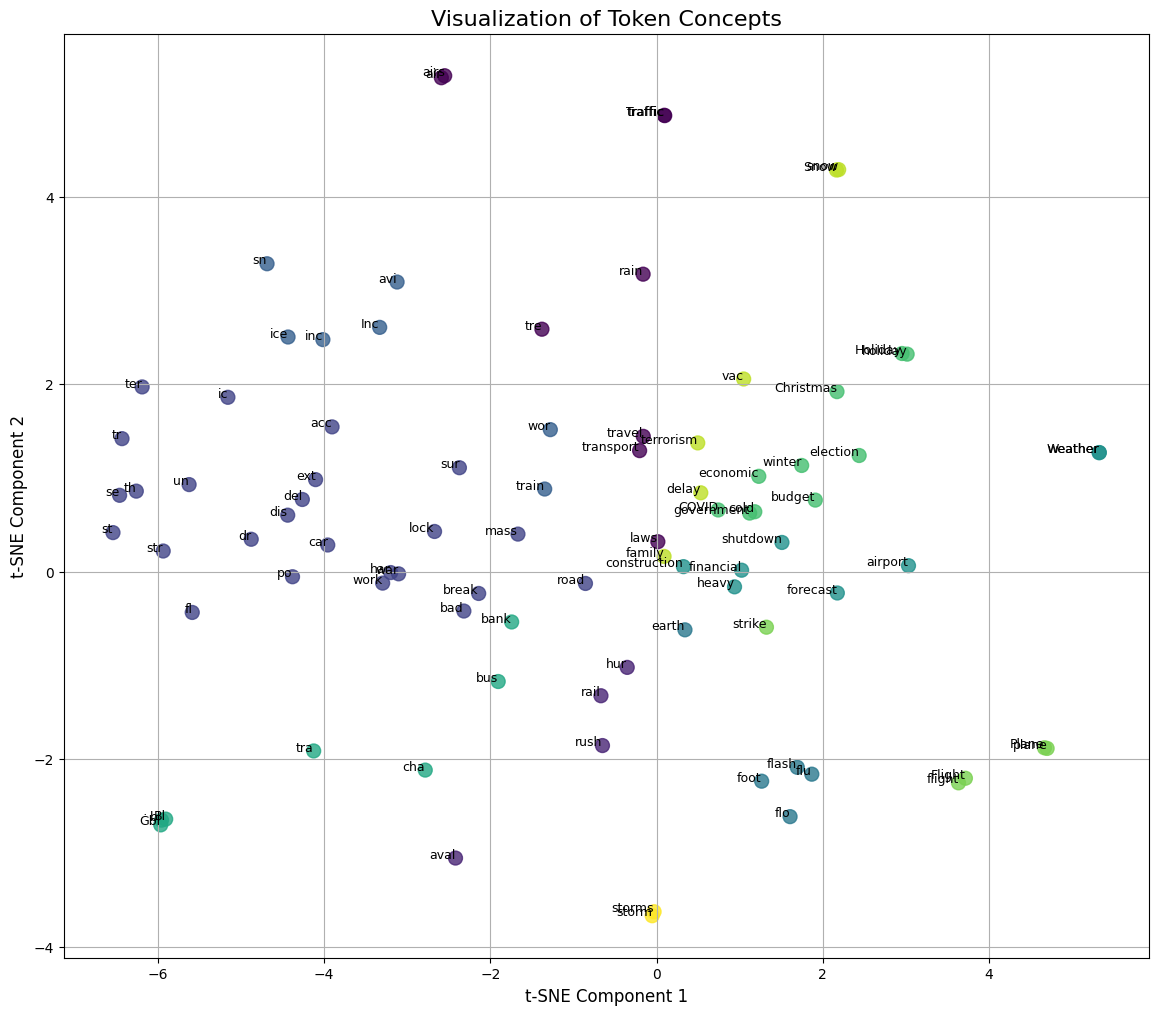

In [128]:
# --- Visualize the results ---
plt.figure(figsize=(14, 12))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.8, s=100)

# Annotate each point with its token
for i, token in enumerate(final_candidates):
    plt.annotate(token.strip(), (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9, ha='right')

plt.title('Visualization of Token Concepts', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
# --- Final Comparison: Autoregressive Concept-Aware vs. Standard Decoder ---

# =================================================================
# --- 1. SETUP ---
# =================================================================
# The common starting point for both generation methods
base_prompt = "Prove sqrt 2 is irrational"
num_tokens_to_generate = 40

# We need the chat template for both methods
formatted_prompt = (
    f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n"
    f"{base_prompt}"
    f"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"
)

print(f"Base Prompt: '{base_prompt}'")
print(f"Tokens to Generate: {num_tokens_to_generate}")


# =================================================================
# --- 2. Run the AUTOREGRESSIVE CONCEPT-AWARE DECODING Process ---
# =================================================================
print("\n--- Running Autoregressive Concept-Aware Decoding (This will be slow) ---")

concept_aware_tokens = []
current_prompt = formatted_prompt

for i in range(num_tokens_to_generate):
    # --- Step A: Get Top-K Candidates ---
    concept_params = SamplingParams(temperature=0.0, logprobs=20, max_tokens=1)
    outputs = llm.generate([current_prompt], concept_params, use_tqdm=False)

    # Check for stop token
    if outputs[0].outputs[0].text == "<|eot_id|>":
        print("--> Model generated end-of-turn token. Stopping generation.")
        break

    logprobs_dict_ids = outputs[0].outputs[0].logprobs[0]
    vocab = llm.get_tokenizer().get_vocab()
    id_to_token = {v: k for k, v in vocab.items()}
    ground_truth_probs = {
        id_to_token[token_id]: math.exp(lp.logprob)
        for token_id, lp in logprobs_dict_ids.items()
    }

    # --- Step B: Clean, Embed, Cluster, and Rank ---
    initial_tokens = list(ground_truth_probs.keys())
    initial_probs = list(ground_truth_probs.values())
    final_candidates, final_probs = filter_and_clean_tokens(initial_tokens, initial_probs)

    if not final_candidates:
        # If cleaning removes everything, fall back to the vanilla choice
        chosen_token = max(ground_truth_probs, key=ground_truth_probs.get)
    else:
        tokenizer = llm.get_tokenizer()
        final_candidate_ids = tokenizer.convert_tokens_to_ids(final_candidates)
        embeddings = get_llama_embeddings(llm, final_candidate_ids)
        reduced_embeddings, cluster_labels = reduce_and_cluster_embeddings(embeddings)
        ranked_concepts = rank_concepts(final_candidates, final_probs, cluster_labels)
        best_concept = ranked_concepts[0]
        chosen_token = select_token_from_best_concept(best_concept, ground_truth_probs)

    # --- Step C: Append the chosen token and continue the loop ---
    concept_aware_tokens.append(chosen_token)
    current_prompt += chosen_token
    print(f"Step {i+1}/{num_tokens_to_generate}: Chose token '{chosen_token.strip()}'")

# Decode the final list of tokens into a single string
concept_aware_generation_text = "".join(concept_aware_tokens)


# =================================================================
# --- 3. Run the STANDARD DECODING Process ---
# =================================================================
print("\n--- Running Standard Generation ---")

generation_params = SamplingParams(temperature=0.7, top_p=0.95, max_tokens=num_tokens_to_generate)
standard_outputs = llm.generate([formatted_prompt], generation_params, use_tqdm=False)
standard_generation_text = standard_outputs[0].outputs[0].text


# =================================================================
# --- 4. Display Final Side-by-Side Results ---
# =================================================================
print("\n" + "="*80)
print("                             FINAL AUTOREGRESSIVE RESULTS")
print("="*80)
print(f"Prompt: \"{base_prompt}...\"")
print("-"*80)
print(f"Standard Generation (temperature=0.7):\n'{standard_generation_text.strip()}'")
print("-"*80)
print(f"Concept-Aware Generation (autoregressive):\n'{concept_aware_generation_text.strip()}'")
print("="*80)